# Демо-экзамен по курсу "Прикладной анализ данных". Вариант 2

Выполнил: **Гаранян Арутюн Эдуардович С22-712**

ВУЗ: **НИЯУ МИФИ г. Москва**

Вставьте ниже скриншот с результатом вашего решения в Leaderboard на Kaggle: https://www.kaggle.com/competitions/lamoda-images-classification/data

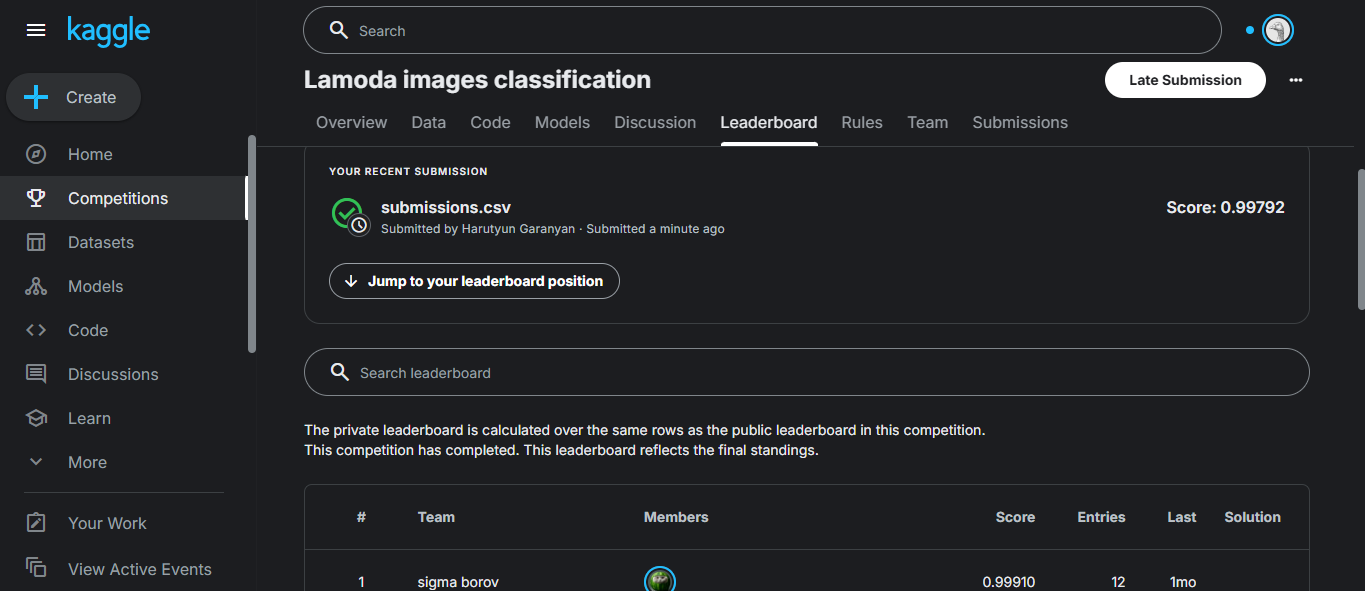


## 1. Описание задачи и данные

В рамках данного задания вам предстоит разработать алгоритм, который автоматически классифицирует изображения предметов одежды на две категории:

- bryuki (брюки),
- bluzy (блузки).

Каждое изображение содержит один предмет одежды на однотонном фоне. Цель — по изображению предсказать, к какому классу принадлежит предмет.

Ссылка на соревнование и на данные: https://www.kaggle.com/competitions/lamoda-images-classification/data

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
from PIL import Image
from collections import defaultdict, Counter
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torchvision import models, transforms
import torch.optim as optim

In [2]:
!pip install opendatasets --quiet

Небольшая инструкция как напрямую скачать данные с kaggle в Colab ноутбук: https://www.geeksforgeeks.org/python/how-to-import-kaggle-datasets-directly-into-google-colab/

In [3]:
import opendatasets as od

url = 'https://www.kaggle.com/competitions/lamoda-images-classification/'
od.download(url)

Please provide your Kaggle credentials to download this dataset. Learn more: http://bit.ly/kaggle-creds
Your Kaggle username: harutyungaranyan
Your Kaggle Key: ··········


100%|██████████| 265M/265M [00:03<00:00, 88.4MB/s]


Extracting archive ./lamoda-images-classification/lamoda-images-classification.zip to ./lamoda-images-classification


## 1. Провести предварительное исследование данных

- сколько у вас есть изображений? Все ли они одного разрешения? Какой баланс классов в данных?
- какие есть особенности датасета?
- если необходимо произвести очистку и предварительную обработку данных.

In [4]:
train_dir = 'lamoda-images-classification/images/train'
test_dir = 'lamoda-images-classification/images/test'

train_files = os.listdir(train_dir)
test_files = os.listdir(test_dir)

print(f"Всего в train: {len(train_files)} изображений")
print(f"Всего в test: {len(test_files)} изображений")

Всего в train: 13476 изображений
Всего в test: 3369 изображений


In [5]:
train_exts = [os.path.splitext(f)[-1].lower() for f in train_files]
test_exts = [os.path.splitext(f)[-1].lower() for f in test_files]

print("Train extensions:", end=" ")
for ext, cnt in Counter(train_exts).items():
    print(f"'{ext}': {cnt}", end='; ')

print("\nTest extensions:", end=" ")
for ext, cnt in Counter(test_exts).items():
    print(f"'{ext}': {cnt}", end='; ')

Train extensions: '.jpg': 13476; 
Test extensions: '.jpg': 3369; 

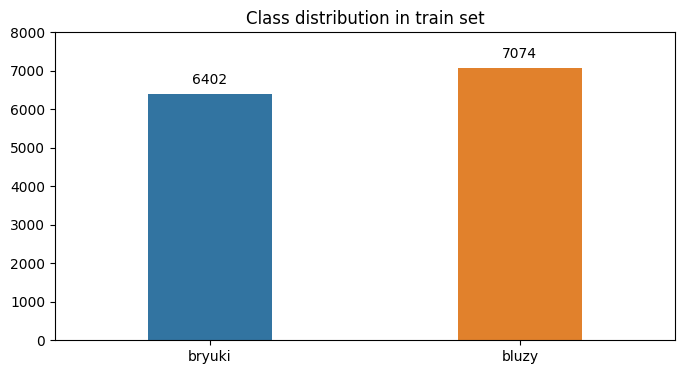

In [6]:
train_labels = ['bluzy' if '_bluzy' in f else 'bryuki' for f in train_files]

fig, ax = plt.subplots(figsize=(8, 4))
cplot = sns.countplot(x=train_labels, width=0.4, hue=train_labels, ax=ax)
for p in cplot.patches:
    cplot.annotate(format(p.get_height(), '.0f'), (p.get_x() + p.get_width() / 2,
                   p.get_height()), ha='center', va='center', xytext=(0, 10),
                   textcoords='offset points')

plt.ylim((0, 8000))
plt.ylabel("")
plt.title("Class distribution in train set")
plt.show()

In [7]:
sizes = []
for fname in train_files:
    path = os.path.join(train_dir, fname)
    try:
        with Image.open(path) as img:
            sizes.append(img.size)
    except:
        print("Проблема с файлом:", fname)

size_counts = Counter(sizes)
print("Уникальные размеры (формат: width x height):")
for s, count in size_counts.items():
    print(f"{s[0]}x{s[1]} — {count} шт.")

Уникальные размеры (формат: width x height):
46x66 — 10597 шт.
600x866 — 2879 шт.


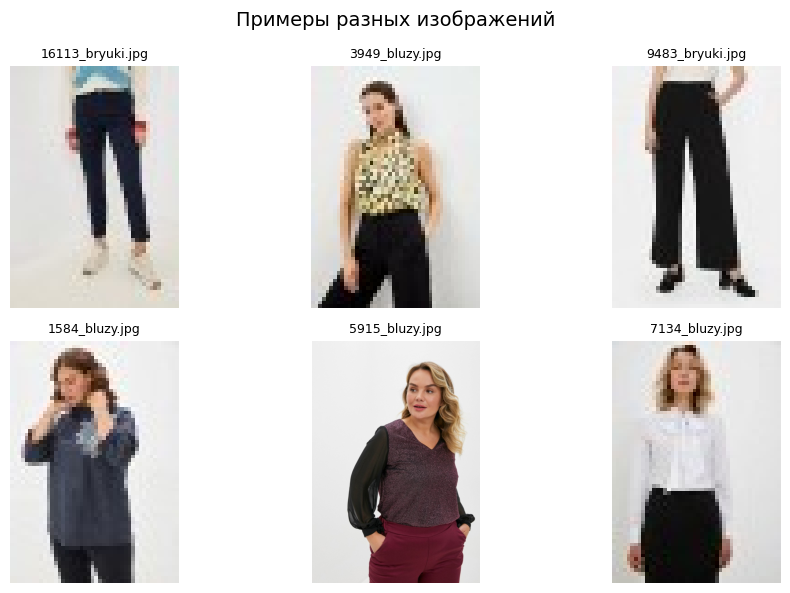

In [8]:
fig, axes = plt.subplots(2, 3, figsize=(10, 6))
shown = 0
sample_files = [f for f in train_files][:6]

for fname in sample_files:
    path = os.path.join(train_dir, fname)
    try:
        image = Image.open(path).convert('RGB')
    except Exception as e:
        print(f"Ошибка открытия {fname}: {e}")
        continue
    ax = axes.flatten()[shown]
    ax.imshow(image)
    ax.set_title(fname, fontsize=9)
    ax.axis('off')
    shown += 1

plt.suptitle("Примеры разных изображений", fontsize=14)
plt.tight_layout()
plt.show()

Итого, что мы можем сказать о нашем датасете?

Всего у нас 16 845 изображений, при этом:
* В обучающем наборе данных 13 476 изображений (80%)
* В тестовом наборе данных 3 369 изображений (20%)

Все изображения в датасете формата .jpg. Значит в дальнейшем нам не придётся обрабатывать случаи загрузки изображений разных форматов, как могло бы быть (например, .jpg, .png и т.д.)

Сами изображения разных размеров. Можем заметить, что в обучающем наборе данных у нас имеется следующее распределение:
* 46x66 — 10 597 изображений (78.6%)
* 600x866 — 2 879 изображений (21.4%)

В том числе поэтому в фрагменте кода выше большинство изображений были выведены некорректно, размыто, так как они размером с маленькую иконку в каталоге Lamoda (а таковых большинство).

Имеется два класса изображений — это брюки и блузки, соответственно:
* Брюки — 6 402 шт. (47.5%)
* Блузки — 7 074 шт. (52.5%)

Баланс классов удовлетворительный, больших колебаний в сторону одного из них — нет (разница 5% — не критична), все файлы открываются без ошибок. Исходя из этого, мы не будем проводить дополнительную предобработку данных, а сразу перейдем к их подготовке для дальнейшего обучения (см. пункт 2)

## 2. Подготовить данные для обучения

- Создать тренировочную и тестовую подвыборки для обучения и тестирования работы моделей
- Создать класс на фреймворке `PyTorch` для создания датасета
- Создать `loader` для передачи данных в модель нейронной сети

In [9]:
class MyDataset(Dataset):
    def __init__(self, file_list, root_dir, transform=None, test_mode=False):
        self.file_list = file_list
        self.root_dir = root_dir
        self.transform = transform
        self.test_mode = test_mode

    def __len__(self):
        return len(self.file_list)

    def __getitem__(self, idx):
        fname = self.file_list[idx]
        img_path = os.path.join(self.root_dir, fname)
        image = Image.open(img_path).convert('RGB')

        if self.transform:
            image = self.transform(image)

        if self.test_mode:
            filename = os.path.basename(img_path)
            return image, filename
        else:
            label_str = fname.split('_')[-1].split('.')[0]
            label = 0 if label_str == 'bluzy' else 1
            return image, label

In [10]:
all_files = [f for f in os.listdir(train_dir)]

np.random.seed(42)
np.random.shuffle(all_files)

n_total = len(all_files)
n_train = int(0.8 * n_total)
train_files = all_files[:n_train]
valid_files = all_files[n_train:]

########################################################################

train_transform = transforms.Compose([
    transforms.RandomResizedCrop(224),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485,0.456,0.406],
                         std=[0.229,0.224,0.225])
])

valid_transform = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485,0.456,0.406],
                         std=[0.229,0.224,0.225])
])

########################################################################

train_data = MyDataset(file_list=train_files,
                       root_dir=train_dir,
                       transform=train_transform)

valid_data = MyDataset(file_list=valid_files,
                       root_dir=train_dir,
                       transform=valid_transform)

########################################################################

train_loader = DataLoader(train_data, batch_size=32, shuffle=True,
                          num_workers=2, persistent_workers=True,
                          prefetch_factor=2, pin_memory=True)

valid_loader = DataLoader(valid_data, batch_size=32, shuffle=False,
                          num_workers=2, persistent_workers=True,
                          prefetch_factor=2, pin_memory=True)

print(f'Число тренировочных примеров: {len(train_data)}')
print(f'Число валидационных примеров: {len(valid_data)}')

Число тренировочных примеров: 10780
Число валидационных примеров: 2696


## 3. Реализация модели

- создать класс для модели
- создать функцию для обучения модели
- создать функцию для валидации модели

In [11]:
class RSNAModel(nn.Module):
    def __init__(self):
        super(RSNAModel, self).__init__()

        self.conv_block = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2),

            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2),

            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2),
        )

        self.flatten = nn.Flatten()
        self.fc = nn.Sequential(
            nn.Linear(128 * 28 * 28, 512),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(512, 2)
        )

    def forward(self, x):
        x = self.conv_block(x)
        x = self.flatten(x)
        x = self.fc(x)
        return x

In [12]:
def train_one_epoch(model, train_loader, optimizer, loss_fn,
                    epoch, device, verbose=False):
    model.train()
    running_loss = 0.0
    correct = total = 0

    for batch_idx, (images, labels) in enumerate(train_loader):
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        loss = loss_fn(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * images.size(0)
        preds = outputs.argmax(1)
        correct += preds.eq(labels).sum().item()
        total += labels.size(0)

        if verbose and batch_idx % 50 == 0:
            print(f'Epoch {epoch}, Batch {batch_idx}, '
                  f'Loss: {loss.item():.4f}')

    epoch_loss = running_loss / total
    epoch_acc = correct / total

    return epoch_loss, epoch_acc


@torch.no_grad()
def valid_one_epoch(model, valid_loader, loss_fn,
                    epoch, device, verbose=False):
    model.eval()
    running_loss = 0.0
    correct = total = 0

    for images, labels in valid_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        loss = loss_fn(outputs, labels)

        running_loss += loss.item() * images.size(0)
        preds = outputs.argmax(1)
        correct += preds.eq(labels).sum().item()
        total += labels.size(0)

    epoch_loss = running_loss / total
    epoch_acc = correct / total

    if verbose:
        print(f'Validation Epoch {epoch}: Loss {epoch_loss:.4f}, '
              f'Acc {epoch_acc:.4%}')

    return epoch_loss, epoch_acc

## 4. Обучение модели
*   Определить необходимые параметры для обучения модели (learning rate, optimizer, loss function, etc)
*   Реализовать процесс обучения модели
*   Оценить эффективность работы модели



In [13]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = RSNAModel()
model = model.to(device)

loss_fn = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-4)

best_val_acc = 0.0
epochs = 10

for epoch in range(1, epochs + 1):
    train_loss, train_acc = train_one_epoch(model, train_loader, optimizer,
                                            loss_fn, epoch, device)

    val_loss, val_acc = valid_one_epoch(model, valid_loader, loss_fn,
                                        epoch, device, verbose=True)

    if val_acc > best_val_acc:
        best_val_acc = val_acc
        torch.save(model.state_dict(), "best_model.pth")
        print(f"Epoch {epoch}: сохранена лучшая модель (val_acc = {val_acc:.4%})")

    print(f"Epoch {epoch}/{epochs} | "
          f"Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.2%} | "
          f"Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.2%}\n")

print(f"Лучшее значение точности на валидации: {best_val_acc:.2%}")

Validation Epoch 1: Loss 0.1147, Acc 95.5119%
Epoch 1: сохранена лучшая модель (val_acc = 95.5119%)
Epoch 1/10 | Train Loss: 0.4074, Train Acc: 80.98% | Val Loss: 0.1147, Val Acc: 95.51%

Validation Epoch 2: Loss 0.0787, Acc 97.0326%
Epoch 2: сохранена лучшая модель (val_acc = 97.0326%)
Epoch 2/10 | Train Loss: 0.2718, Train Acc: 88.46% | Val Loss: 0.0787, Val Acc: 97.03%

Validation Epoch 3: Loss 0.0554, Acc 98.5905%
Epoch 3: сохранена лучшая модель (val_acc = 98.5905%)
Epoch 3/10 | Train Loss: 0.2462, Train Acc: 89.34% | Val Loss: 0.0554, Val Acc: 98.59%

Validation Epoch 4: Loss 0.0503, Acc 99.1840%
Epoch 4: сохранена лучшая модель (val_acc = 99.1840%)
Epoch 4/10 | Train Loss: 0.2199, Train Acc: 90.82% | Val Loss: 0.0503, Val Acc: 99.18%

Validation Epoch 5: Loss 0.0530, Acc 99.2953%
Epoch 5: сохранена лучшая модель (val_acc = 99.2953%)
Epoch 5/10 | Train Loss: 0.2125, Train Acc: 91.20% | Val Loss: 0.0530, Val Acc: 99.30%

Validation Epoch 6: Loss 0.0340, Acc 99.3694%
Epoch 6: сохра

## 5. Экспериментальная часть

- протестировать не менее 3х разных моделей для решения задачи
- сравнить их эффективность (по метрикам и потерям)
- сделать выводы

In [14]:
def get_model(name):
    weights_dict = {
        'resnet18': models.ResNet18_Weights.DEFAULT,
        'resnet50': models.ResNet50_Weights.DEFAULT,
        'efficientnet_b0': models.EfficientNet_B0_Weights.DEFAULT
    }

    if name not in weights_dict:
        raise ValueError(f"Unknown model name: {name}")

    model_fn = getattr(models, name)
    weights = weights_dict[name]
    model = model_fn(weights=weights)

    if name.startswith('resnet'):
        in_f = model.fc.in_features
        model.fc = nn.Linear(in_f, 2)
    elif name.startswith('efficientnet'):
        in_f = model.classifier[1].in_features
        model.classifier[1] = nn.Linear(in_f, 2)

    return model

In [15]:
def run_experiment(model_name, train_loader, valid_loader, device, epochs=10):
    model = get_model(model_name).to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)
    loss_fn = nn.CrossEntropyLoss()

    best_val_acc, best_val_loss = 0.0, float('inf')

    for epoch in range(1, epochs + 1):
        train_loss, train_acc = train_one_epoch(model, train_loader, optimizer,
                                                loss_fn, epoch, device)
        val_loss, val_acc = valid_one_epoch(model, valid_loader, loss_fn,
                                            epoch, device, verbose=True)

        if val_acc > best_val_acc:
            best_val_acc, best_val_loss = val_acc, val_loss
            torch.save({
                'epoch': epoch,
                'model_state': model.state_dict(),
                'opt_state': optimizer.state_dict()
            }, f"best_{model_name}.pth")
            print(f"Epoch {epoch}: сохранена лучшая модель {model_name} (val_acc = {val_acc:.4%})")

        print(f"{model_name} Epoch {epoch}/{epochs} | "
              f"Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.2%} | "
              f"Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.2%}\n")

    return {
        'model': model_name,
        'best_val_acc': best_val_acc,
        'best_val_loss': best_val_loss
    }

In [16]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
results = []
for name in ['resnet18', 'resnet50', 'efficientnet_b0']:
    stats = run_experiment(name, train_loader, valid_loader, device)
    results.append(stats)

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 181MB/s]


Validation Epoch 1: Loss 0.0162, Acc 99.4807%
Epoch 1: сохранена лучшая модель resnet18 (val_acc = 99.4807%)
resnet18 Epoch 1/10 | Train Loss: 0.1355, Train Acc: 94.62% | Val Loss: 0.0162, Val Acc: 99.48%

Validation Epoch 2: Loss 0.0125, Acc 99.4807%
resnet18 Epoch 2/10 | Train Loss: 0.0912, Train Acc: 96.34% | Val Loss: 0.0125, Val Acc: 99.48%

Validation Epoch 3: Loss 0.0150, Acc 99.4065%
resnet18 Epoch 3/10 | Train Loss: 0.0789, Train Acc: 96.88% | Val Loss: 0.0150, Val Acc: 99.41%

Validation Epoch 4: Loss 0.0078, Acc 99.8145%
Epoch 4: сохранена лучшая модель resnet18 (val_acc = 99.8145%)
resnet18 Epoch 4/10 | Train Loss: 0.0733, Train Acc: 97.08% | Val Loss: 0.0078, Val Acc: 99.81%

Validation Epoch 5: Loss 0.0086, Acc 99.8145%
resnet18 Epoch 5/10 | Train Loss: 0.0742, Train Acc: 97.16% | Val Loss: 0.0086, Val Acc: 99.81%

Validation Epoch 6: Loss 0.0127, Acc 99.5549%
resnet18 Epoch 6/10 | Train Loss: 0.0682, Train Acc: 97.43% | Val Loss: 0.0127, Val Acc: 99.55%

Validation Epoch

Downloading: "https://download.pytorch.org/models/resnet50-11ad3fa6.pth" to /root/.cache/torch/hub/checkpoints/resnet50-11ad3fa6.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 192MB/s]


Validation Epoch 1: Loss 0.0149, Acc 99.5178%
Epoch 1: сохранена лучшая модель resnet50 (val_acc = 99.5178%)
resnet50 Epoch 1/10 | Train Loss: 0.1537, Train Acc: 93.99% | Val Loss: 0.0149, Val Acc: 99.52%

Validation Epoch 2: Loss 0.0178, Acc 99.4065%
resnet50 Epoch 2/10 | Train Loss: 0.0932, Train Acc: 96.60% | Val Loss: 0.0178, Val Acc: 99.41%

Validation Epoch 3: Loss 0.0093, Acc 99.7774%
Epoch 3: сохранена лучшая модель resnet50 (val_acc = 99.7774%)
resnet50 Epoch 3/10 | Train Loss: 0.0814, Train Acc: 96.82% | Val Loss: 0.0093, Val Acc: 99.78%

Validation Epoch 4: Loss 0.0199, Acc 99.2582%
resnet50 Epoch 4/10 | Train Loss: 0.0770, Train Acc: 97.14% | Val Loss: 0.0199, Val Acc: 99.26%

Validation Epoch 5: Loss 0.0154, Acc 99.5178%
resnet50 Epoch 5/10 | Train Loss: 0.0656, Train Acc: 97.67% | Val Loss: 0.0154, Val Acc: 99.52%

Validation Epoch 6: Loss 0.0119, Acc 99.6291%
resnet50 Epoch 6/10 | Train Loss: 0.0588, Train Acc: 97.94% | Val Loss: 0.0119, Val Acc: 99.63%

Validation Epoch

Downloading: "https://download.pytorch.org/models/efficientnet_b0_rwightman-7f5810bc.pth" to /root/.cache/torch/hub/checkpoints/efficientnet_b0_rwightman-7f5810bc.pth
100%|██████████| 20.5M/20.5M [00:00<00:00, 109MB/s] 


Validation Epoch 1: Loss 0.0109, Acc 99.6662%
Epoch 1: сохранена лучшая модель efficientnet_b0 (val_acc = 99.6662%)
efficientnet_b0 Epoch 1/10 | Train Loss: 0.1542, Train Acc: 94.35% | Val Loss: 0.0109, Val Acc: 99.67%

Validation Epoch 2: Loss 0.0127, Acc 99.6662%
efficientnet_b0 Epoch 2/10 | Train Loss: 0.1009, Train Acc: 96.18% | Val Loss: 0.0127, Val Acc: 99.67%

Validation Epoch 3: Loss 0.0093, Acc 99.7774%
Epoch 3: сохранена лучшая модель efficientnet_b0 (val_acc = 99.7774%)
efficientnet_b0 Epoch 3/10 | Train Loss: 0.0733, Train Acc: 97.12% | Val Loss: 0.0093, Val Acc: 99.78%

Validation Epoch 4: Loss 0.1201, Acc 99.6662%
efficientnet_b0 Epoch 4/10 | Train Loss: 0.0735, Train Acc: 97.41% | Val Loss: 0.1201, Val Acc: 99.67%

Validation Epoch 5: Loss 0.0061, Acc 99.8145%
Epoch 5: сохранена лучшая модель efficientnet_b0 (val_acc = 99.8145%)
efficientnet_b0 Epoch 5/10 | Train Loss: 0.0639, Train Acc: 97.66% | Val Loss: 0.0061, Val Acc: 99.81%

Validation Epoch 6: Loss 0.0087, Acc 99.

In [17]:
df = pd.DataFrame(results)
display(df)

,model,best_val_acc,best_val_loss
0,resnet18,0.998145,0.007834
1,resnet50,0.997774,0.009313
2,efficientnet_b0,0.998516,0.005354


Как мы видим из всех трёх моделей лучше всего себя показал efficientnet_b0

Дальнейший порядок действий у нас такой:
* Возьмем модель efficientnet_b0
* Прогоним её на тестовых данных
* Сохраним результаты в итоговый dataframe
* Запишем их в файл формата .csv

In [18]:
test_files = os.listdir(test_dir)

test_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406],
                         [0.229, 0.224, 0.225])
])

test_dataset = MyDataset(test_files, root_dir=test_dir,
                         transform=test_transform, test_mode=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False,
                         num_workers=1)

model = get_model('efficientnet_b0')
checkpoint = torch.load('best_efficientnet_b0.pth', map_location=device)
model.load_state_dict(checkpoint['model_state'])
model = model.to(device)
model.eval()

results = []
with torch.no_grad():
    for images, filenames in test_loader:
        images = images.to(device)
        outputs = model(images)
        preds = outputs.argmax(1).cpu().numpy()

        for fname, pred in zip(filenames, preds):
            label = 'bluzy' if pred == 0 else 'bryuki'
            results.append({'index': fname, 'label': label})

df = pd.DataFrame(results)
df.to_csv('submissions.csv', index=False)